In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# Usually CuDNN has heuristics as to which algorithm to pick, that, roughly, depend on the input shape, strides (aka memory layout) and dtype.
# Setting cudnn.benchmark, the CuDNN library will benchmark several algorithms and pick that which it found to be fastest
cudnn.bencmark = True
# cudnn.deterministic will only allow those CuDNN algorithms that are (believed to be) deterministic.

plt.ion() # interactive mode

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

In [28]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'hymenoptera_data'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in ['train', 'val']
}
class_names = image_datasets['train'].classes
print(f"class names: {class_names}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class names: ['ants', 'bees']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


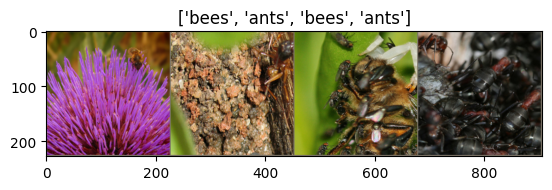

In [10]:
def imshow(inp, title=None):
  """Display image for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)

  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

# Get a batch of training data
input, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(input)

imshow(out, title=[class_names[x] for x in classes])

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

  since = time.time()

  # Create a temporary directory to save training checkpoints
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
        if phase == 'train':
          model.train()
        else:
          model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # Forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), best_model_params_path)

      time_elapsed = time.time() - since
      print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
      print(f'Best val Acc: {best_acc:4f}')

      model.load_state_dict(torch.load(best_model_params_path))

    return model

In [13]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5622 Acc: 0.7664
val Loss: 0.2127 Acc: 0.8954
Training complete in 0m 4s
Best val Acc: 0.895425
Epoch 1/24
----------
train Loss: 0.5074 Acc: 0.8033
val Loss: 0.2431 Acc: 0.9020
Training complete in 0m 10s
Best val Acc: 0.901961
Epoch 2/24
----------
train Loss: 0.3343 Acc: 0.8525
val Loss: 0.2834 Acc: 0.9216
Training complete in 0m 14s
Best val Acc: 0.921569
Epoch 3/24
----------
train Loss: 0.4488 Acc: 0.8156
val Loss: 0.3587 Acc: 0.8497
Training complete in 0m 17s
Best val Acc: 0.921569
Epoch 4/24
----------
train Loss: 0.4355 Acc: 0.8279
val Loss: 0.3688 Acc: 0.8562
Training complete in 0m 22s
Best val Acc: 0.921569
Epoch 5/24
----------
train Loss: 0.4439 Acc: 0.8402
val Loss: 0.2238 Acc: 0.9150
Training complete in 0m 26s
Best val Acc: 0.921569
Epoch 6/24
----------
train Loss: 0.3574 Acc: 0.8607
val Loss: 0.1982 Acc: 0.9216
Training complete in 0m 30s
Best val Acc: 0.921569
Epoch 7/24
----------
train Loss: 0.3864 Acc: 0.8566
val Loss: 0.2109 Acc: 0.9346
Training c

In [26]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      print(f"outputs shape: {outputs.shape}")
      print(f"outputs: {outputs}")
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size(0)):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


outputs shape: torch.Size([4, 2])
outputs: tensor([[ 2.6653, -2.3011],
        [ 2.0373, -1.0792],
        [ 2.3315, -3.1277],
        [ 0.3784, -0.9629]], device='cuda:0')


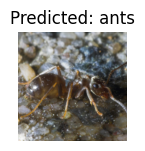

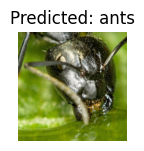

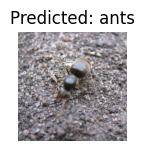

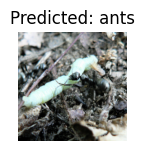

outputs shape: torch.Size([4, 2])
outputs: tensor([[-2.5162,  3.5832],
        [-1.5148, -1.1902],
        [-3.0983,  3.8763],
        [ 1.3325,  0.1750]], device='cuda:0')


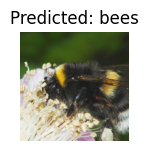

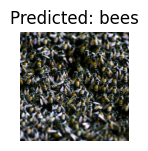

In [27]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

In [29]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR y by a factory of 0.1 every epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [30]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.7389 Acc: 0.6270
val Loss: 0.9853 Acc: 0.5490
Training complete in 0m 6s
Best val Acc: 0.549020
Epoch 1/24
----------
train Loss: 0.4016 Acc: 0.7910
val Loss: 0.2351 Acc: 0.9281
Training complete in 0m 11s
Best val Acc: 0.928105
Epoch 2/24
----------
train Loss: 0.5474 Acc: 0.7500
val Loss: 0.2046 Acc: 0.9477
Training complete in 0m 17s
Best val Acc: 0.947712
Epoch 3/24
----------
train Loss: 0.5440 Acc: 0.7869
val Loss: 0.6201 Acc: 0.7582
Training complete in 0m 24s
Best val Acc: 0.947712
Epoch 4/24
----------
train Loss: 0.5051 Acc: 0.7828
val Loss: 0.2133 Acc: 0.9281
Training complete in 0m 29s
Best val Acc: 0.947712
Epoch 5/24
----------
train Loss: 0.4784 Acc: 0.7951
val Loss: 0.2782 Acc: 0.8954
Training complete in 0m 35s
Best val Acc: 0.947712
Epoch 6/24
----------
train Loss: 0.3827 Acc: 0.8320
val Loss: 0.3393 Acc: 0.8758
Training complete in 0m 39s
Best val Acc: 0.947712
Epoch 7/24
----------
train Loss: 0.4014 Acc: 0.8074
val Loss: 0.1926 Acc: 0.9346
Training c

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


outputs shape: torch.Size([4, 2])
outputs: tensor([[ 1.2100, -0.0979],
        [ 0.8539,  0.6412],
        [ 1.4067, -0.7446],
        [-2.5549,  3.9192]], device='cuda:0')


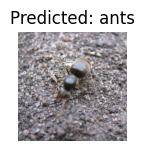

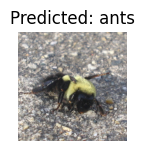

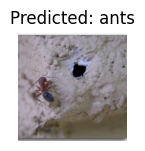

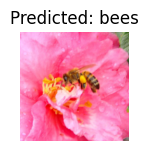

outputs shape: torch.Size([4, 2])
outputs: tensor([[ 1.8875, -1.1097],
        [-2.7018,  4.9944],
        [-0.8975,  2.7083],
        [ 0.6921, -0.4461]], device='cuda:0')


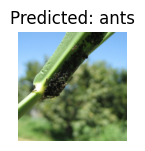

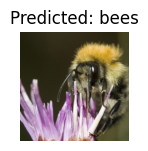

In [31]:
visualize_model(model_conv)

plt.ioff()
plt.show()